# 【开源实习】针对任务类型Image-to-Text，开发可在香橙派AIpro开发板运行的应用
任务编号：#ICJ6EP  
任务链接：[【开源实习】针对任务类型Image-to-Text，开发可在香橙派AIpro开发板运行的应用](https://gitee.com/mindspore/community/issues/ICJ6EP)  


## 环境准备
开发者拿到香橙派开发板后，首先需要进行硬件资源确认，镜像烧录及CANN和MindSpore版本的升级，才可运行该案例，具体如下：

开发板：香橙派Aipro或其他同硬件开发板  
开发板镜像: Ubuntu镜像  
CANN Toolkit/Kernels：8.0.0.beta1  
MindSpore: 2.6.0  
MindSpore NLP: 0.4.1  
Python: 3.9

### 镜像烧录
运行该案例需要烧录香橙派官网ubuntu镜像，烧录流程参考[昇思MindSpore官网--香橙派开发专区--环境搭建指南--镜像烧录](https://www.mindspore.cn/tutorials/zh-CN/r2.7.0rc1/orange_pi/environment_setup.html) 章节。

### CANN升级
CANN升级参考[昇思MindSpore官网--香橙派开发专区--环境搭建指南--CANN升级](https://www.mindspore.cn/tutorials/zh-CN/r2.7.0rc1/orange_pi/environment_setup.html)章节。

### MindSpore升级
MindSpore升级参考[昇思MindSpore官网--香橙派开发专区--环境搭建指南--MindSpore升级](https://www.mindspore.cn/tutorials/zh-CN/r2.7.0rc1/orange_pi/environment_setup.html)章节。

### 权重加载
此处使用MindSpore NLP套件加载`Salesforce/blip-image-captioning-base`模型权重，该套件包含了许多自然语言处理的常用方法，可以方便地加载和使用modelers的模型权重。  
BLIP是由Salesforce研究团队于2022年提出的多模态预训练框架，旨在突破视觉与语言的跨模态理解瓶颈，实现更高效、更通用的图像与文本交互能力。
在本次任务中，我们将基于昇思MindSpore在香橙派开发板上运行Blip-base模型，体验图像生成文本的功能。  
注意：首次运行时请耐心等待模型下载。

In [1]:
!pip install --upgrade pip
!pip install mindnlp==0.4.1
!pip install opencv-python
!pip install pillow
!pip install numpy==1.26.4
!pip install sympy

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/15/31/9dffc70da6b9bbf7968f6551967fc21156207366272c2a40b4ed6008dc9b/numpy-2.0.2-cp39-cp39-manylinux_2_17_aarch64.manylinux2014_aarch64.whl (13.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mindspore 2.6.0 requires numpy<2.0.0,>=1.20.0, but you have numpy 2.0.2 which is incompatible.
pyctcdecode 0.5.0 requires numpy<2.0.0,>=1.15.0, but you have numpy 2.0.2 which is incompatible.
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi

In [2]:
import os
import time
import cv2  
import mindspore
import numpy as np
from IPython.display import clear_output, display
from mindnlp.transformers import BlipForConditionalGeneration, BlipProcessor
from mindspore import Tensor, context
from PIL import Image

# 导入镜像源
os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"


/usr/local/miniconda3/envs/img/lib/python3.9/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/miniconda3/envs/img/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/usr/local/miniconda3/envs/img/lib/python3.9/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/miniconda3/envs/img/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


# 加载模型

In [3]:

processor = BlipProcessor.from_pretrained(
    "Salesforce/blip-image-captioning-base",
    ms_dtype=mindspore.float16,
)
model = BlipForConditionalGeneration.from_pretrained(
    "Salesforce/blip-image-captioning-base",
    ms_dtype=mindspore.float16,
    low_cpu_mem_usage=True,
)

model.set_train(False)

/usr/local/miniconda3/envs/img/lib/python3.9/site-packages/mindnlp/transformers/tokenization_utils_base.py:1526: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted, and will be then set to `False` by default. 
  warnings.warn(
BlipTextLMHeadModel has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`.`PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


[MS_ALLOC_CONF]Runtime config:  enable_vmm:True  vmm_align_size:2MB


BlipForConditionalGeneration(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear (768 -> 2304)
            (projection): Linear (768 -> 768)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELU(approximate='none')
            (fc1): Linear (768 -> 3072)
            (fc2): Linear (3072 -> 768)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (text_decoder): BlipTextLMHeadModel(
    (bert): BlipTextModel(
      (embeddings): BlipTe

# 固定输入
固定模型输入图像大小，避免每次传入新尺寸图像都需要重新编译花费大量时间 

In [4]:
# 创建固定尺寸的输入模板 - 避免每次重新编译
fixed_size = (384, 384)  # 使用BLIP的标准输入尺寸
dummy_image = Image.new("RGB", fixed_size, color=(0, 0, 0))
dummy_inputs = processor(dummy_image, return_tensors="ms")

print("预编译模型（首次运行需要1-2分钟）...")
start = time.time()
_ = model.generate(**dummy_inputs, max_length=20)
print(f"预编译完成！耗时: {time.time() - start:.2f}秒")

预编译模型（首次运行需要1-2分钟）...
预编译完成！耗时: 214.89秒


# 模型推理
定义模型处理图像的方法，并将模型推理结果返回

In [5]:
def process_image(image_path):
    """读取图片并生成描述"""
    if not os.path.exists(image_path):
        return "❌ 文件不存在"

    cv_image = cv2.imread(image_path)
    if cv_image is None:
        return "❌ 无法读取图像"

    # 转 RGB + 缩放
    cv_image = cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB)
    cv_image = cv2.resize(cv_image, fixed_size)
    raw_image = Image.fromarray(cv_image)

    # 推理
    inputs = processor(raw_image, return_tensors="ms")
    outputs = model.generate(**inputs, max_length=30, do_sample=False, num_beams=1)

    caption = processor.decode(outputs[0], skip_special_tokens=True)

    # 显示图片
    display(Image.open(image_path))

    return caption

# 启动图生文应用
创建一个用户交互输入框，用户可以将要推理的模型路径输入至输入框中，模型会将用户输入图像及推理结果展示。  
输入stop终止程序

请输入图像路径
用户:  /opt/image2text/shixi/test.png

Blip：

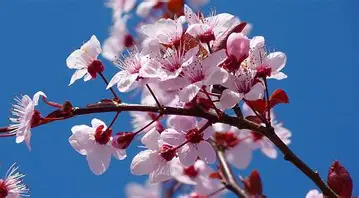

a tree with pink flowers against a blue sky
请输入图像路径
用户:  stop


In [6]:
while True:
    print("请输入图像路径")
    img_path = input("\n用户：请输入图像路径")
    print("用户: ",img_path)
    if img_path.strip() == "stop":
        break
    print("\nBlip：", end="")
    infer = process_image(img_path)
    print(infer)